In [1]:
import torch
import norse
import norse.torch as snn
import torch.nn as nn
from tqdm import tqdm
from generate_tasks.cognitive_task import ContextDM
from exponent_filter import ExpFilter
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {("gpu (cuda)" if device.type=="cuda" else "cpu")}')

class SNNMULTYTASK(torch.nn.Module):
    def __init__(self, feature_size, hidden_size, output_size) -> None:
        super(SNNMULTYTASK, self).__init__()
        self.lif = snn.LIFRecurrent(feature_size, hidden_size)
        self.exp_f = ExpFilter(hidden_size, output_size, 0.75)
        #self.linear = nn.Linear(hidden_size, output_size)
    def forward(self, x):
        out, state = self.lif(x) 
       #out = self.linear(out) 
        out = self.exp_f(out)       
        return (out, state)
        

('ContextDM', {'dt': 0.001})
('CompareObjects', {'dt': 0.001})
Good
Device: gpu (cuda)


In [2]:


# 0. Create dataset
t_fixation = .3
t_target = .35
t_trial = .75
t_delay = .3 #300 - 1500 (.3s - 1.5s)

f_time = 6000
dt = 1e-3
params = dict([('sigma', 0.1), 
              ('fixation', t_fixation),
              ('target', t_target),
              ('delay', t_delay),
              ('trial', t_trial),
              ('time', f_time),
              ('dt', dt)])
batch_size = 20
CDM_task = ContextDM(params, batch_size)

#inputs, labels, ob_size, act_size = CDM_task.dataset()


feature_size, output_size = CDM_task.feature_and_act_size
hidden_size = 1000

# 1. model


    
model = SNNMULTYTASK(feature_size, hidden_size, output_size).to(device)
with torch.no_grad():
    weights_pre_l = []
    for name, param in model.named_parameters(): 
        if param.requires_grad: 
            weights_pre_l.append((param).cpu().numpy())
            #print (name, param.data)

# 2. loss and optimizer
learning_rate = 1e-2
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
running_loss = 0.0

# 3. train loop
for i in (range(1000)):
    inputs, target_outputs = CDM_task.dataset()
    inputs = torch.from_numpy(inputs).type(torch.float).to(device)  
    target_outputs = torch.from_numpy(target_outputs).type(torch.float).to(device)

    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs, states = model(inputs)
    
    loss = criterion(outputs, target_outputs)
    loss.backward()
    optimizer.step()

    # print statistics
    running_loss += loss.item()
    if i % 10 == 9:
        print('epoch: {:d} loss: {:0.5f}'.format(i + 1, running_loss / 10))
        running_loss = 0.0
        with torch.no_grad():
            inputs, target_outputs = CDM_task.dataset()
            inputs = torch.from_numpy(inputs).type(torch.float).to(device)  
            target_outputs = torch.from_numpy(target_outputs).type(torch.float).to(device)
            outputs, states = model(inputs)
            loss = criterion(outputs, target_outputs)
            print('test loss: {:0.5f}'.format(loss.item()))
            
            
        
       

print('Finished Training')


epoch: 10 loss: 0.79906
test loss: 0.16223
epoch: 20 loss: 0.13394
test loss: 0.10814
epoch: 30 loss: 0.09186
test loss: 0.07675
epoch: 40 loss: 0.06696
test loss: 0.04666
epoch: 50 loss: 0.05158
test loss: 0.06581
epoch: 60 loss: 0.05495
test loss: 0.05384
epoch: 70 loss: 0.04662
test loss: 0.03818
epoch: 80 loss: 0.04350
test loss: 0.04121
epoch: 90 loss: 0.04065
test loss: 0.03571
epoch: 100 loss: 0.04311
test loss: 0.04683
epoch: 110 loss: 0.04051
test loss: 0.04189
epoch: 120 loss: 0.04109
test loss: 0.03365
epoch: 130 loss: 0.04322
test loss: 0.04063
epoch: 140 loss: 0.04001
test loss: 0.03913
epoch: 150 loss: 0.03894
test loss: 0.03190
epoch: 160 loss: 0.03791
test loss: 0.04095
epoch: 170 loss: 0.04111
test loss: 0.03185
epoch: 180 loss: 0.04287
test loss: 0.03992
epoch: 190 loss: 0.03567
test loss: 0.05694
epoch: 200 loss: 0.04089
test loss: 0.05354
epoch: 210 loss: 0.14213
test loss: 0.08961
epoch: 220 loss: 0.05348
test loss: 0.04366
epoch: 230 loss: 1.95036
test loss: 0.097

KeyboardInterrupt: 

In [ ]:
inputs, target_outputs = CDM_task.dataset()
target_outputs.shape
print(target_outputs.shape)
inputs = torch.from_numpy(inputs).type(torch.float).to(device)  
model(inputs)[0].size()

(1999, 10, 3)


torch.Size([1999, 10, 3])

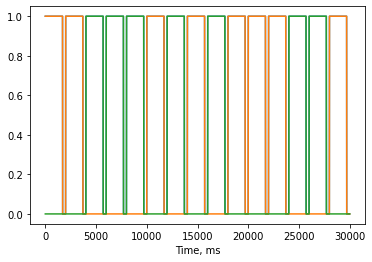

inputs.shape = (29985, 1, 5)
outputs.shape = (29985, 1, 3)


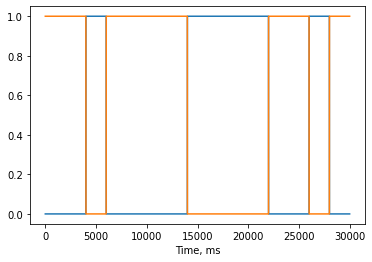

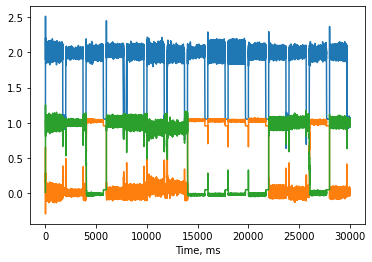

In [3]:
import matplotlib.pyplot as plt
import numpy as np
# 0. Create dataset
t_fixation = .3
t_target = .35
t_trial = .75
t_delay = .3 #300 - 1500 (.3s - 1.5s)

f_time = 30000
dt = 1e-3
params = dict([('sigma', .1), 
              ('fixation', t_fixation),
              ('target', t_target),
              ('delay', t_delay),
              ('trial', t_trial),
              ('time', f_time),
              ('dt', dt)])
batch_size = 1
CDM_task = ContextDM(params, batch_size)
inputs, labels = CDM_task.dataset()
plt.plot(inputs[:, 0, 0])
plt.plot(inputs[:, 0, 3])
plt.plot(inputs[:, 0, 4])
plt.xlabel('Time, ms')
plt.show()
plt.close()
inputs = torch.from_numpy(inputs).type(torch.float).to(device)  
feature_size, output_size = CDM_task.feature_and_act_size
hidden_size = 400

# 1. model

if False:
    
    model = SNNMULTYTASK(feature_size, hidden_size, output_size).to(device)
    with torch.no_grad():
        for name, param in model.named_parameters(): 
            param.copy_(torch.from_numpy( np.load(f'./data/{name}.npy')).to(device))
#labels = torch.from_numpy(labels.flatten()).type(torch.long).to(device)
with torch.no_grad():
    outputs, state = model(inputs)
    inputs = inputs.cpu().numpy() 
    outputs = outputs.cpu().numpy()
    print(f'inputs.shape = {inputs.shape}')
    print(f'outputs.shape = {outputs.shape}')
    
    #plt.plot(labels[:, 0, 0])
    plt.plot(labels[:, 0, 1])
    plt.plot(labels[:, 0, 2])
    #plt.xlim([0, 1000])
    plt.xlabel('Time, ms')
    plt.show()
    plt.close()
    #plt.plot(outputs[:, 0, 2])
    plt.plot(outputs[:, 0, 0] + 1)
    plt.plot(outputs[:, 0, 1])
    plt.plot(outputs[:, 0, 2])
    #plt.xlim([0, 300])
    plt.xlabel('Time, ms')
    plt.show()
    plt.close()
    


In [ ]:
#import numpy as np
#with torch.no_grad():
    #weights_after_l = []
    #for name, param in model.named_parameters(): 
        #np.save(f'./data/{name}', param.cpu())       
            #print (name, param.data)

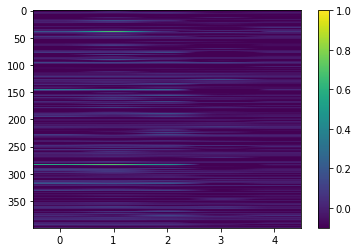

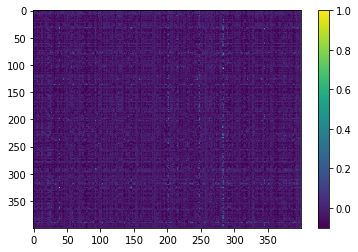

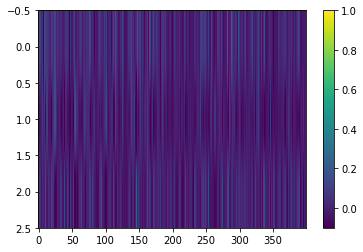

In [ ]:
with torch.no_grad():
    weights_after_l = []
    for name, param in model.named_parameters(): 
        if param.requires_grad: 
            weights_after_l.append((param).cpu().numpy())
            #print (name, param.data)
            
for i in range(len(weights_after_l) - 1):
    plt.imshow(weights_after_l[i] -weights_pre_l[i], aspect ='auto', vmax=1, vmin=-0.1)
    plt.colorbar()
    plt.show()
    plt.close()

after


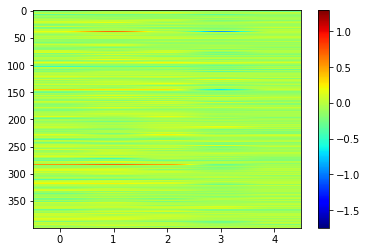

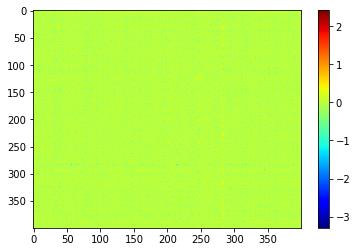

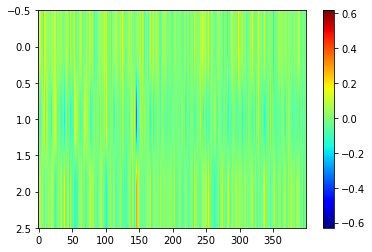

pre


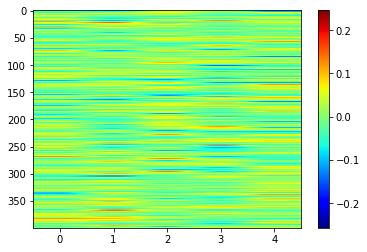

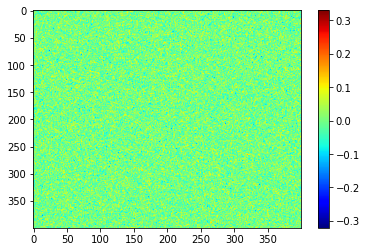

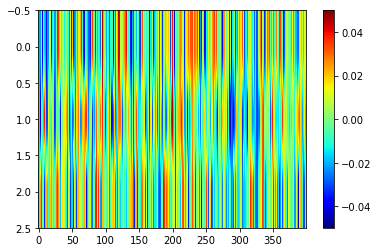

TypeError: Invalid shape (3,) for image data

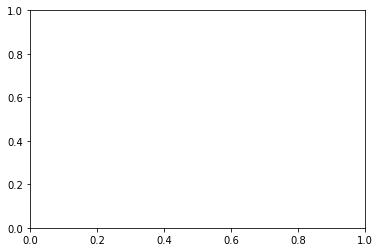

In [ ]:

print('after')
for i in range(len(weights_after_l) - 1):
    plt.imshow(weights_after_l[i], aspect ='auto', cmap='jet')
    plt.colorbar()
    plt.show()
    plt.close()
print('pre')
for i in range(len(weights_after_l)):
    plt.imshow(weights_pre_l[i], aspect ='auto', cmap='jet')
    plt.colorbar()
    plt.show()
    plt.close()